# AntiSplodge Evaluation Notebook
This Notebook provides an interface to evaluate pre-trained AntiSplodge models with arbitrary input data and compare it with SpotNMatch performance.

In [19]:
import anndata as ann
import scanpy as sc
import matplotlib.pyplot as plot
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import torch

import antisplodge as AS

from collections import Counter

from scstmatch.deconvolution.evaluation import evaluate_jsd, evaluate_rmse
from scstmatch.data import SingleCellDataset, SpatialTranscriptomicsDataset
from scstmatch.matching import SpotNMatch

In [8]:
class Signature:
    def __init__(self, sig: tuple[list[str], list[str]]):
        self.genes = sig[0]
        self.cell_types = sig[1]


class Reference:
    def __init__(self, dataset: SingleCellDataset, signature: Signature, model: AS.CelltypeDeconvolver):
        self.dataset = dataset
        self.signature = signature
        self.model = model

## Import
We import the signatures and the models to properly match deconvolution performance on different datasets.

In [9]:
DATA_PATH = "../../data"
REFERENCE_PATH = f"{DATA_PATH}/reference"
REFERENCE_DATASETS = {
    ("Harvard", "full", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female.sc.h5ad",
    ("Harvard", "V1", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female_-muscles.sc.h5ad",
    ("Harvard", "V2", "F"): f"{REFERENCE_PATH}/hca_harvard_gender_Female_-endothelial.sc.h5ad",
    ("Sanger", "full", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female.sc.h5ad",
    ("Sanger", "V1", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female_-muscles.sc.h5ad",
    ("Sanger", "V2", "F"): f"{REFERENCE_PATH}/hca_sanger_gender_Female_-endothelial.sc.h5ad",
}

references = {}

for name, path in REFERENCE_DATASETS.items():
    with open(f"{name[0]}_gender_female_{name[1]}.signature.pickle", "rb") as f:
        signature = Signature(pickle.load(f))
    dataset = SingleCellDataset.read(path)
    experiment = AS.DeconvolutionExperiment(dataset.anndata[:, signature.genes])
    experiment.setCellTypeColumn(dataset.cell_type_column)
    experiment.num_features = len(signature.genes)
    experiment.setupModel(cuda_id=0)
    model = experiment.model
    model.load_state_dict(torch.load(f"{name[0]}_gender_female_{name[1]}.model.pt", map_location=model.Get("device")))
    references[name] = Reference(dataset, signature, model)

We import the target datasets with known profiles.

In [10]:
TARGET_PATH = f"{DATA_PATH}/st"
TARGET_DATASETS = {
    ("Harvard", "full", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6.st.h5ad",
    ("Harvard", "V1", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6_-muscles.st.h5ad",
    ("Harvard", "V2", "H6"): f"{TARGET_PATH}/hca_harvard_donor_H6_-endothelial.st.h5ad",
    ("Sanger", "full", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5.st.h5ad",
    ("Sanger", "V1", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5_-muscles.st.h5ad",
    ("Sanger", "V2", "D5"): f"{TARGET_PATH}/hca_sanger_donor_D5_-endothelial.st.h5ad",
    ("Harvard", "full", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7.st.h5ad",
    ("Harvard", "V1", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7_-muscles.st.h5ad",
    ("Harvard", "V2", "H7"): f"{TARGET_PATH}/hca_harvard_donor_H7_-endothelial.st.h5ad",
    ("Sanger", "full", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1.st.h5ad",
    ("Sanger", "V1", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1_-muscles.st.h5ad",
    ("Sanger", "V2", "D1"): f"{TARGET_PATH}/hca_sanger_donor_D1_-endothelial.st.h5ad",
}

targets = {}

for name, path in TARGET_DATASETS.items():
    targets[name] = SpatialTranscriptomicsDataset.read(path)

## Processing

### AntiSplodge
We apply the AntiSplodge models to the target datasets and evaluate the performance.

In [26]:
as_predictions = {}

as_jsd_spots = {}
as_jsd_mean = []
as_rmse_spots = {}
as_rmse_mean = []

for ref, reference in references.items():
    for name, target in targets.items():
        target_data = target.copy_with(target.anndata[:, reference.signature.genes].copy())
        sc.pp.normalize_total(target_data.anndata, target_sum=1)
        X = torch.tensor(target_data.anndata.X.todense(), device=reference.model.Get("device"))
        Y_pred = reference.model.forward(X).detach().clamp(min=0).cpu().numpy()
        Y_pred /= Y_pred.sum(axis=1)[:, np.newaxis]
        key = (ref, name)
        predicted = pd.DataFrame(Y_pred, columns=reference.signature.cell_types)
        as_predictions[key] = predicted

        as_jsd_spots[key] = evaluate_jsd(target, predicted)
        as_jsd_mean.append(as_jsd_spots[key].mean())
        as_rmse_spots[key] = evaluate_rmse(target, predicted)
        as_rmse_mean.append(as_rmse_spots[key].mean())

/Users/potti/Documents/HPI/thesis/spatialtranscriptomics/st_data_gen/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:1297: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


### SpotNMatch
We use SpotNMatch to find the matching score values.

In [27]:
scores = {}
mean_score = []

for ref, reference in references.items():
    matcher = SpotNMatch(reference.dataset)
    for name, target in targets.items():
        scores[(ref, name)] = matcher.match(target)[3]
        mean_score.append(scores[(ref, name)].mean())

0.019419s	init train
5.883782s	load
3.085713s	nnls
3.024162s	nnls
2.896396s	nnls
3.322314s	nnls
2.864963s	nnls
2.882906s	nnls
2.878371s	nnls
2.645419s	nnls
3.013649s	nnls
2.707002s	nnls
2.583832s	nnls
2.664837s	nnls
0.007305s	init train
2.063744s	load
1.036992s	nnls
1.050068s	nnls
1.057545s	nnls
1.039104s	nnls
1.025408s	nnls
1.041765s	nnls
1.044602s	nnls
1.079314s	nnls
1.121999s	nnls
1.081990s	nnls
1.092269s	nnls
1.152391s	nnls
0.016651s	init train
5.610054s	load
2.652241s	nnls
2.691825s	nnls
2.712906s	nnls
2.581280s	nnls
2.686143s	nnls
2.690440s	nnls
2.590300s	nnls
2.491273s	nnls
2.395446s	nnls
2.519889s	nnls
2.382239s	nnls
2.332540s	nnls
0.014424s	init train
3.115190s	load
2.374685s	nnls
2.438411s	nnls
2.409445s	nnls
2.446496s	nnls
2.653480s	nnls
2.721283s	nnls
2.419510s	nnls
2.402929s	nnls
2.453145s	nnls
2.595676s	nnls
2.739527s	nnls
2.635768s	nnls
0.007185s	init train
1.166844s	load
0.726888s	nnls
0.732420s	nnls
0.722263s	nnls
0.747801s	nnls
0.719929s	nnls
0.712739s	nnls
0.828809s	

## Plotting
We plot the results and investigate the correlation.

In [28]:
plot.rcParams.update({
    "text.usetex": True,
})

array([[ 1.        , -0.69731127],
       [-0.69731127,  1.        ]])

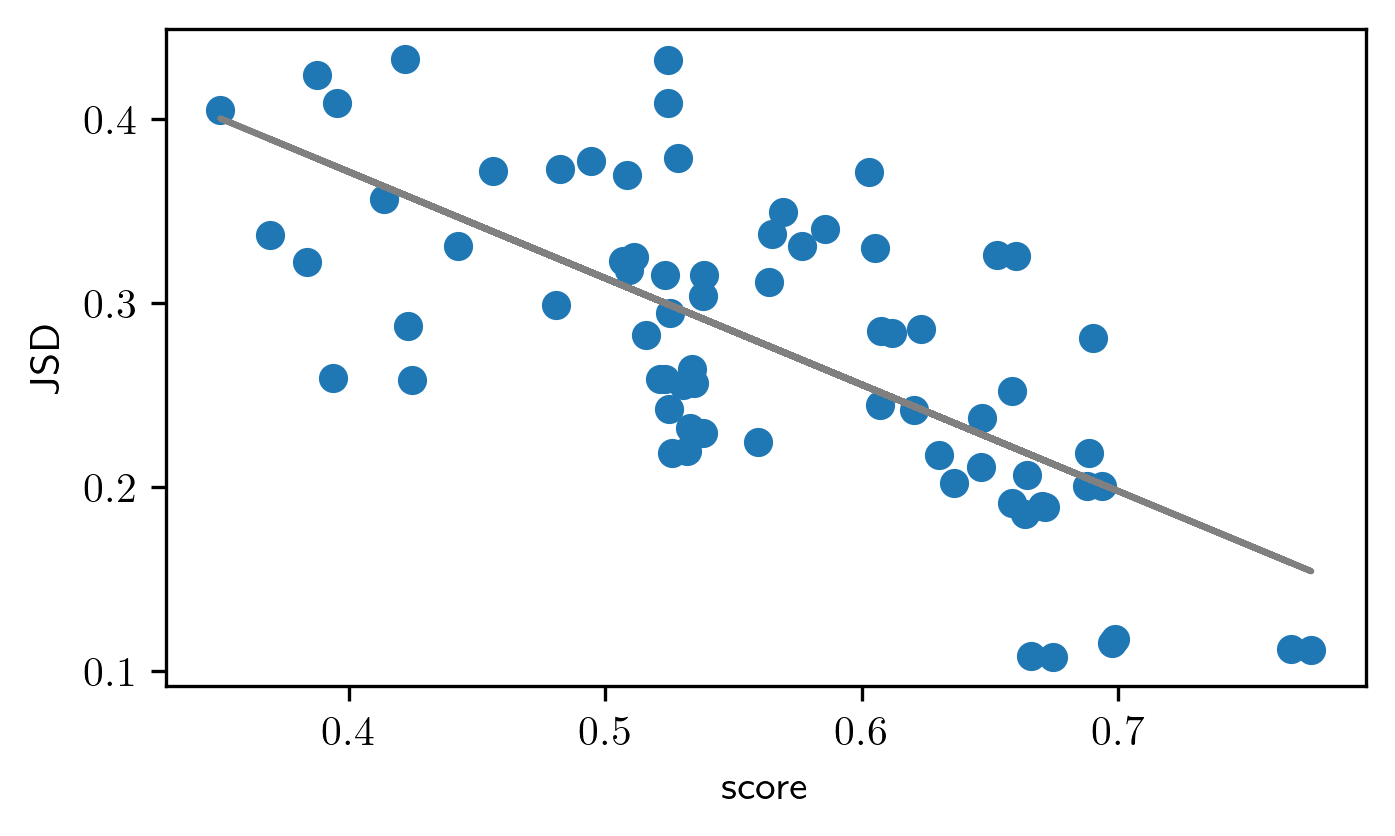

In [54]:
fig = plot.figure(figsize=(5, 3), dpi=300)
fig.subplots_adjust(left=0.15, right=0.95, bottom=0.15)
plt = fig.add_subplot()
plt.set_xlabel("score")
plt.set_ylabel("JSD")

b, a = np.polyfit(mean_score, as_jsd_mean, deg=1)
Y = np.polyval([b, a], mean_score)
plt.plot(mean_score, Y, color="grey")

plt.scatter(mean_score, as_jsd_mean)

fig.savefig("antisplodge_correlation_jsd.pdf")
np.corrcoef(mean_score, as_jsd_mean)

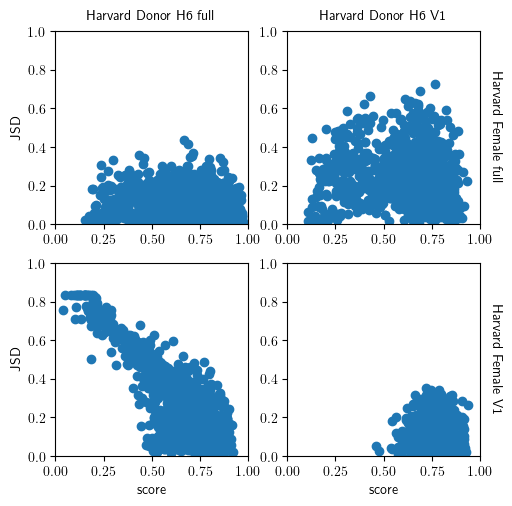

In [50]:
reference_keys = list(REFERENCE_DATASETS.keys())[0:2]
reference_labels = list(map(lambda x: f"{x[0]} Female {x[1]}", reference_keys))
n_cols = len(reference_keys)

target_keys = list(TARGET_DATASETS.keys())[0:2]
target_labels = list(map(lambda x: f"{x[0]} Donor {x[2]} {x[1]}", target_keys))
n_rows = len(target_keys)

figure, grid = plot.subplots(n_cols, n_rows, figsize=(5,5))
min_x, min_y = 0.1, 0.1
max_x, max_y = 0.95, 0.95
figure.subplots_adjust(min_x, min_y, max_x, max_y)
x_range = max_x - min_x
y_range = max_y - min_y

for label, index in zip(reference_labels, range(n_rows)):
    grid[index][n_cols - 1].text(1.05, 0.5, label, ha="left", va="center", rotation=-90)
    grid[index][0].set_ylabel("JSD")

for label, index in zip(target_labels, range(n_cols)):
    grid[0][index].text(0.5, 1.05, label, va="bottom", ha="center")
    grid[n_cols - 1][index].set_xlabel("score")

for ref, axes in zip(REFERENCE_DATASETS.keys(), grid):
    for tgt, ax in zip(TARGET_DATASETS.keys(), axes):
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.scatter(scores[(ref, tgt)], as_jsd_spots[(ref, tgt)])

figure.savefig("antisplodge_correlation_jsd_excerpt.pdf")